In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import LeaveOneOutEncoder, BinaryEncoder, WOEEncoder
sns.set(font_scale=1.3, style='whitegrid')

## Brainstorming
- Bigger weights for `amount_borrowed`, `borrowed_in_months`, `n_bankruptcies`
- Filling NaN of `ok_since` with 0? Expect the worst?
- Clip income due to outliers


## Reading the data

In [2]:
df_train = pd.read_csv('puzzle_train_dataset.csv')

## Remove clients that do not have the target variable

In [3]:
df_train.dropna(axis=0, subset=['default'], inplace=True)
df_train['default'] = df_train['default'].astype(bool)
feature_columns = df_train.columns.drop(['ids', 'default'])

In [4]:
df_train.dtypes

ids                    object
default                  bool
score_1                object
score_2                object
score_3               float64
score_4               float64
score_5               float64
score_6               float64
risk_rate             float64
amount_borrowed       float64
borrowed_in_months    float64
credit_limit          float64
reason                 object
income                float64
sign                   object
gender                 object
facebook_profile       object
state                  object
zip                    object
channel                object
job_name               object
real_state             object
ok_since              float64
n_bankruptcies        float64
n_defaulted_loans     float64
n_accounts            float64
n_issues              float64
dtype: object

## Describing the categorical columns
- The column `sign` has a lot of missing data, so I decided to drop it. I also wonder if it would be useful at all for default prediction...
- The column `channel` is equal to all the clients, so I dropped it.
- The column `facebook_profile` has around 10% of missing data. I will fill it with a placeholder.
- The column `gender` has around 5% of missing data. I will fill it with a placeholder.
- The column `job_name` has around 5% of missing data. I will fill it with a placeholder.
- The column `reason` has only 5 missing values out of 59966. Because of the small amount, I decided to fill in with a placeholder. 
- In the column `reason`, out of its 19496 unique values, more than 16700 are unique to a client. So I decided to replace the less frequent with a new category,
- The feature `job_name` has more than 42000 unique values, where almost 38000 are unique to a single person. So I will replace the less frequent values with a new category.

### Encoding the categorical variables
- Label encoding makes more sense when an order can be inferred from the categorical variables (e.g. Class A, B and C in a football league). As the data is encrypted, I am not able to interpret it properly to extract any order out of it. Because of that, I will use **LeaveOneOut encoding** for the columns `score_1`, `score_2`, `state`, `real_state` and `zip`, which should help reduce overfitting instead of a Target mean encoding, for example.
- Due to the high cardinality, even after the category pruning, I decided to try a **binary encoding** on the columns `reason` and `job_name`.
- I decided to use **LabelEncoding** for gender and facebook_profile

In [5]:
categorical_columns = df_train.select_dtypes('object').columns
describe_df = df_train[categorical_columns].describe().T
describe_df['missing_rate'] = (len(df_train) - describe_df['count']) / len(df_train)
describe_df

,count,unique,top,freq,missing_rate
ids,59966,59966,124287c4-9e03-80ca-eedb-cc41f378533b,1,0
score_1,59966,7,DGCQep2AE5QRkNCshIAlFQ==,20484,0
score_2,59966,35,osCzpM4hJrxugqWWuZmMWw==,5058,0
reason,59961,19496,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,5921,8.33806e-05
sign,41028,12,libr,5582,0.315812
gender,56970,2,m,38497,0.0499616
facebook_profile,53995,2,False,33997,0.0995731
state,59966,50,xsd3ZdsI3356I3xMxZeiqQ==,10212,0
zip,59966,830,3k2JCQ8Bp5oDwaI39ZJgHA==,775,0
channel,59966,1,NCqL3QBx0pscDnx3ixKwXg==,59966,0


### More than 16700 reasons are unique to one person

In [6]:
df_train['reason'].value_counts().value_counts()

1      16772
2       1193
3        467
4        225
5        157
       ...  
441        1
58         1
74         1
106        1
119        1
Name: reason, Length: 124, dtype: int64

### Almost 38000 job names are unique to one person

In [7]:
df_train['job_name'].value_counts().value_counts()

1     37935
2      2460
3       746
4       311
5       196
      ...  
78        1
81        1
47        1
79        1
40        1
Name: job_name, Length: 65, dtype: int64

In [8]:
feature_columns = feature_columns.drop(['sign', 'channel'])
# df_train.dropna(subset=['reason'], inplace=True)

## Describing the numerical columns
- The column `ok_since` has a missing rate bigger than 58%, so I decided to remove it.
- By analysing the missing data in the columns `n_bankruptcies`, `n_defaulted_loans` and `n_issues`, I noticed that they are missing only for clients with missing data in `credit_limit`. Among the clients without the `credit_limit` information, the values of `n_defaulted_loans` are only NaN and 0, so I decided it to fill it with a placeholder; regarding the values of `n_bankruptcies`, it is zero for more than 95% of the clients withou credit limit, so I filled it with a placeholder as well.
- I strongly believe that the feature `n_issues` is an engineered feature of Nubank clients, such as the amount of complainings via chat or amount of disputed charges on his/her credit card. Because of this reason, I decided not to use it, considering fresh clients that request a loan.
- In addition, due to the high amount of missing data in the `credit_limit` column, I decided to not use it. A nice test would be to use the output of Nubank's credit limit regression model to fill in these gaps and see if it would improve the default prediction.
- The `income` column has an extremely high value, which is most likely an outlier. My decision was to clip the `income` column on 2000000.

In [9]:
numerical_columns = df_train.select_dtypes('number').columns
describe_df = df_train[numerical_columns].describe().T
describe_df['missing_rate'] = (len(df_train) - describe_df['count']) / len(df_train)
describe_df

,count,mean,std,min,25%,50%,75%,max,missing_rate
score_3,59966.0,346.435147,109.842822,0.000000,270.000000,340.000000,420.000000,9.900000e+02,0.000000
score_4,59966.0,99.999870,3.174459,86.191572,97.856471,100.008497,102.134785,1.139782e+02,0.000000
score_5,59966.0,0.498721,0.288653,0.000035,0.250013,0.497755,0.748461,9.999734e-01,0.000000
score_6,59966.0,99.943175,10.035178,60.663039,93.213368,99.979923,106.691523,1.424301e+02,0.000000
risk_rate,59966.0,0.294114,0.101183,0.000000,0.220000,0.290000,0.360000,9.000000e-01,0.000000
amount_borrowed,59966.0,13411.805468,7957.402823,527.070000,7225.987500,12012.400000,18036.645000,3.505960e+04,0.000000
borrowed_in_months,59966.0,40.674649,9.504775,36.000000,36.000000,36.000000,36.000000,6.000000e+01,0.000000
credit_limit,41187.0,34093.005997,36783.480509,0.000000,9907.000000,25338.000000,46759.500000,6.131170e+05,0.313161
income,59966.0,71325.776783,51691.429992,4821.180000,44027.857500,60047.260000,85039.612500,5.000028e+06,0.000000
ok_since,24877.0,35.276762,21.630884,0.000000,17.000000,32.000000,50.000000,1.410000e+02,0.585148


### Income boxplot

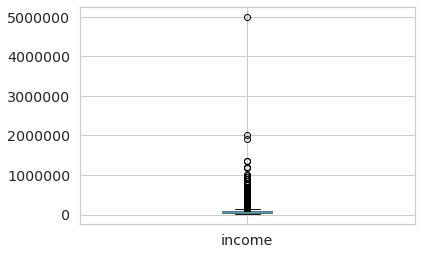

In [10]:
df_train['income'].plot(kind='box')

### Bankruptcies amont clients without `credit_limit`

In [11]:
df_train[df_train['credit_limit'].isna()]['n_bankruptcies'].unique()

array([ 0.,  1., nan,  2.])

In [12]:
df_train[df_train['credit_limit'].isna()]['n_bankruptcies'].value_counts() / len(df_train[df_train['credit_limit'].isna()])

0.0    0.954577
1.0    0.034453
2.0    0.000213
Name: n_bankruptcies, dtype: float64

### Amount of defaulted loans amont clients without `credit_limit`

In [13]:
df_train[df_train['credit_limit'].isna()]['n_defaulted_loans'].unique()

array([ 0., nan])

### Dropping the columns `credit_limit`, `ok_since` and `n_issues`

In [14]:
feature_columns = feature_columns.drop(['credit_limit', 'ok_since', 'n_issues'])

# Building the pipeline using `fklearn`
A couple months back, I came across Nubank's library `fklearn`, but I have not stopped to try it out and read more about it. I decided this was the perfect opportunity to give it a try, and maybe even provide some feedback on it. I followed this [notebook](https://github.com/nubank/fklearn/blob/master/docs/source/examples/regression.ipynb) to get to know the basics.

### Wrapper for the `category_encoders` lib methods.
Inspired by the source code of `standard_scaler`, I created an auxiliary function that wraps the encoding function of the lib `category_encoders`, such as Leave One Out, Weight of Evidence, Hashing, Binary, etc. 

In [97]:
from numpy import nan
from typing import Any, List, Dict, Callable
from toolz import curry
from fklearn.common_docstrings import learner_return_docstring, learner_pred_fn_docstring
from fklearn.training.utils import log_learner_time
from fklearn.training.transformation import apply_replacements
from fklearn.types import LearnerFnType, LearnerReturnType, LogType
from sklearn.base import BaseEstimator
@curry
@log_learner_time(learner_name='category_encoder_wrapper')
def category_encoder_wrapper(df: pd.DataFrame,
                             target_column: str,
                             encoder_function: BaseEstimator,
                             columns_to_encode: List[str]) -> LearnerReturnType:
    """
    Fits an encoder of the library category-encoders to the dataset.

    Parameters
    ----------

    df : pandas.DataFrame
        A Pandas' DataFrame with columns to scale.
        It must contain all columns listed in `columns_to_encode`.

    columns_to_encode : list of str
        A list of names of the columns for standard scaling.
    """

    encoder = encoder_function()

    encoder.fit(df[columns_to_encode], df[target_column])

    def p(new_data_set: pd.DataFrame) -> pd.DataFrame:
        new_data = encoder.transform(new_data_set[columns_to_encode])
        if len(columns_to_encode) == new_data.shape[1]: # Replaces the columns
            new_cols = pd.DataFrame(data=new_data, columns=columns_to_encode).to_dict('list')
            return new_data_set.assign(**new_cols)
        # Else, the encoder creates new columns
        new_data.columns = ('fklearn_feat__' + new_data.columns).str.rsplit('_', 1).str.join('==')
        return new_data_set.assign(**new_data).drop(columns_to_encode, axis=1)
        
        

    p.__doc__ = learner_pred_fn_docstring("category_encoder_wrapper")

    log = {'category_encoder_wrapper': {
        'encoder': encoder.get_params(),
        'transformed_column': columns_to_encode}}

    return p, p(df), log

category_encoder_wrapper.__doc__ += learner_return_docstring("Category Encoder Wrapper")

### Encoding the categorical variables
- Label encoding makes more sense when an order can be inferred from the categorical variables (e.g. Class A, B and C in a football league). As the data is encrypted, I am not able to interpret it properly to extract any order out of it. Because of that, I will use **LeaveOneOut encoding** for the columns `score_1`, `score_2`, `state`, `real_state` and `zip`, which should help reduce overfitting instead of a Target mean encoding, for example.
- Due to the high cardinality, even after the category pruning, I decided to try a **binary encoding** on the columns `reason` and `job_name`.
- I decided to use **LabelEncoding** for `gender` and `facebook_profile` 

Fixed a seed just for reproducibility.

In [98]:
SEED = 123

from fklearn.training.imputation import placeholder_imputer
from fklearn.training.transformation import capper, selector, truncate_categorical, label_categorizer
from fklearn.training.pipeline import build_pipeline
from category_encoders import LeaveOneOutEncoder, BinaryEncoder

# Select the columns for training
# If any learner arguments is either a numpy array or a pandas Series, the line 43 in the script `pipeline.py`
# throws a ValueError exception. I would suggest replacing it with the following:
#  [p for p, a in signature(my_selector).parameters.items() if isinstance(a.default, str) and a.default == '__no__default__']
# That is why I casted `feature_columns` to a list
my_selector = selector(training_columns=list(feature_columns) + ['default'])

# NaN imputation anc capping the income
columns_to_impute = ['facebook_profile', 'gender', 'job_name', 'reason', 'n_bankruptcies', 'n_defaulted_loans']
my_placeholder_imputer = placeholder_imputer(columns_to_impute=columns_to_impute)
my_income_capper = capper(columns_to_cap=['income'], precomputed_caps={'income': 2000000})

# Categorical variables encoding
my_categ_truncate = truncate_categorical(columns_to_truncate=['job_name', 'reason'], percentile=1/len(df_train),
                                         replacement="Other", replace_unseen ="Other")
my_leaveoneout_encoder = category_encoder_wrapper(target_column='default', encoder_function=LeaveOneOutEncoder,
                                                  columns_to_encode=['score_1', 'score_2', 'state', 'real_state', 'zip'])
my_binary_encoder = category_encoder_wrapper(target_column='default', encoder_function=BinaryEncoder, 
                                             columns_to_encode=['reason', 'job_name'])
my_label_encoder = label_categorizer(columns_to_categorize=['gender', 'facebook_profile'])

### Splitting into train and test (holdout set)
Since this data does not have a temporal component, I randomly sampled 20% to be the holdout set

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train['default'], test_size=0.2, 
                                                    random_state=SEED, shuffle=True, stratify=df_train['default'])

In [104]:
from fklearn.training.classification import lgbm_classification_learner
my_lgbm = lgbm_classification_learner(
    features=list(feature_columns),
    target='default',
    prediction_column='prediction',
    extra_params={'seed': SEED, 'nthread': 8},
)

lgbm_pipeline = build_pipeline(
    my_selector, my_placeholder_imputer, my_income_capper, my_categ_truncate, 
    my_leaveoneout_encoder, my_binary_encoder, my_label_encoder,
    my_lgbm
)

(pred_fn_lgbm, lgbm_out, logs) = lgbm_pipeline(X_train)

In [105]:
from fklearn.training.classification import xgb_classification_learner
my_xgb = xgb_classification_learner(
    features=list(feature_columns),
    target='default',
    prediction_column='prediction',
    extra_params={'seed': SEED, 'nthread': 8, 'maxdepth': 4},
)

xgb_pipeline = build_pipeline(
    my_selector, my_placeholder_imputer, my_income_capper, my_categ_truncate, 
    my_leaveoneout_encoder, my_binary_encoder, my_label_encoder,
    my_xgb
)

(pred_fn_xgb, xgb_out, logs) = xgb_pipeline(X_train)

In [106]:
from fklearn.training.classification import logistic_classification_learner
my_logistic = logistic_classification_learner(
    features=list(feature_columns),
    target='default',
    prediction_column='prediction',
    params={'random_state': SEED, 'n_jobs': -1, 'class_weight': None},
)

logistic_pipeline = build_pipeline(
    my_selector, my_placeholder_imputer, my_income_capper, my_categ_truncate, 
    my_leaveoneout_encoder, my_binary_encoder, my_label_encoder,
    my_logistic
)

(pred_fn_logistic, logistic_out, logs) = logistic_pipeline(X_train)

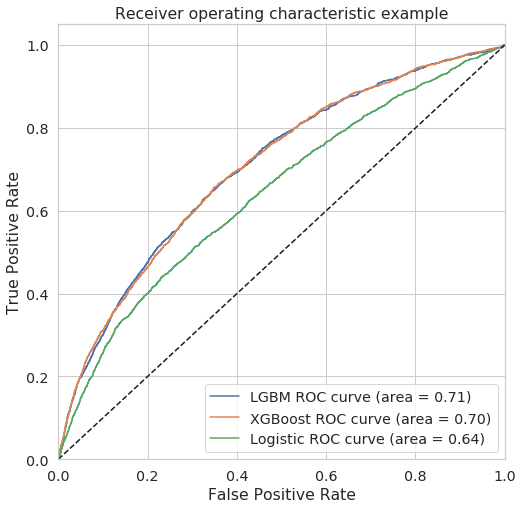

In [107]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(8,8))

for (pred_fn, model_name) in zip([pred_fn_lgbm, pred_fn_xgb, pred_fn_logistic],
                                 ['LGBM', 'XGBoost', 'Logistic']):
    fpr, tpr, thrs = roc_curve(y_test, pred_fn(X_test)['prediction'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (model_name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

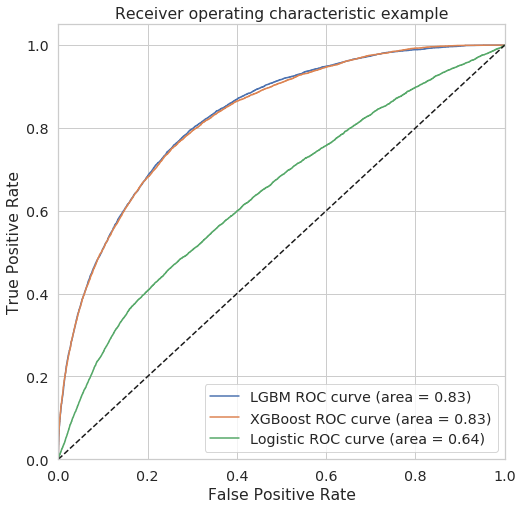

In [108]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(8,8))

for (train_out, model_name) in zip([lgbm_out, xgb_out, logistic_out],
                                 ['LGBM', 'XGBoost', 'Logistic']):
    fpr, tpr, thrs = roc_curve(y_train, train_out['prediction'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (model_name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Grid search

In [170]:
from fklearn.validation.splitters import k_fold_splitter
split_fn = k_fold_splitter(n_splits=5, random_state=SEED, stratify_column='default')

params_space = {
    'learning_rate': lambda: [1e-3, 1e-2, 1e-1, 1],
    'num_estimators': lambda: [20, 100, 200, 300]
}

from toolz.functoolz import curry
@curry
def param_train_fn(space, train_set):
    my_xgb = xgb_classification_learner(
        features=list(feature_columns),
        target='default',
        prediction_column='prediction',
        learning_rate=space['learning_rate'],
        num_estimators=space['num_estimators'],
        extra_params={'seed': SEED, 'nthread': 8, 'maxdepth': 4}
    )

    pipeline = build_pipeline(
        my_selector, my_placeholder_imputer, my_income_capper, my_categ_truncate, 
        my_leaveoneout_encoder, my_binary_encoder, my_label_encoder,
        my_xgb
    )
    return pipeline(train_set)

from fklearn.validation.evaluators import roc_auc_evaluator
from fklearn.tuning.parameter_tuners import grid_search_cv
tuning_log = grid_search_cv(params_space, df_train, param_train_fn, split_fn, 
                            roc_auc_evaluator(target_column='default'), n_jobs=4)

In [171]:
from fklearn.tuning.utils import *
from fklearn.metrics.pd_extractors import extract, evaluator_extractor

In [172]:
result_list = []
for log in tuning_log:
    df_log = pd.DataFrame(log['validator_log'])
    df_log['roc_auc'] = df_log['eval_results'].map(lambda x: x[0]['roc_auc_evaluator__default'])
    iter_space = pd.Series(log['iter_space']).to_dict()
    for param, value in iter_space.items():
        df_log[param] = value
    df_log.drop(['eval_results', 'split_log'], axis=1, inplace=True)
    result_list.append(df_log)
    
gridsearch_result = pd.concat(result_list)

In [173]:
auc_mean = gridsearch_result.groupby(['learning_rate', 'num_estimators'])['roc_auc'].mean()
auc_std = gridsearch_result.groupby(['learning_rate', 'num_estimators'])['roc_auc'].std()

In [174]:
auc_mean.round(5).astype('str') + ' +- ' + auc_std.round(5).astype('str')

learning_rate  num_estimators
0.001          20.0              0.69351 +- 0.00693
               100.0             0.69655 +- 0.00578
               200.0             0.69767 +- 0.00515
               300.0              0.6987 +- 0.00497
0.010          20.0              0.69766 +- 0.00508
               100.0             0.70176 +- 0.00531
               200.0              0.7041 +- 0.00507
               300.0             0.70458 +- 0.00457
0.100          20.0              0.70385 +- 0.00483
               100.0              0.7025 +- 0.00335
               200.0             0.69921 +- 0.00384
               300.0             0.69597 +- 0.00433
1.000          20.0               0.6693 +- 0.00489
               100.0             0.63399 +- 0.00688
               200.0             0.63031 +- 0.00368
               300.0             0.63233 +- 0.00498
Name: roc_auc, dtype: object

In [39]:
prediction_function(X_test)

,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,amount_borrowed,borrowed_in_months,income,...,job_name_8,job_name_9,job_name_10,job_name_11,job_name_12,job_name_13,job_name_14,job_name_15,job_name_16,prediction
32710,0.180477,0.146593,220.0,99.791167,0.362976,91.890306,0.21,4813.61,36.0,30016.80,...,0,0,0,0,0,0,0,0,0,0.179313
48549,0.180477,0.212723,340.0,100.294893,0.902335,90.738296,0.38,2024.17,36.0,24019.57,...,0,0,0,0,0,0,0,0,0,0.032078
31598,0.117866,0.104394,370.0,98.984264,0.933744,116.783979,0.38,19747.86,36.0,45530.16,...,1,1,0,0,0,1,0,1,1,0.073162
21373,0.117866,0.132628,370.0,99.726744,0.880557,81.547633,0.32,15013.31,36.0,65031.65,...,0,0,0,0,0,0,0,0,0,0.210516
53163,0.302158,0.298799,290.0,95.166986,0.055290,108.147291,0.39,20034.22,36.0,110451.75,...,0,0,0,0,0,0,0,0,0,0.387636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64095,0.117866,0.115119,480.0,98.238469,0.187499,118.376911,0.25,2425.48,36.0,39016.52,...,0,0,0,0,0,0,0,0,0,0.170328
19990,0.057554,0.063245,370.0,102.782249,0.898249,103.722546,0.27,13017.21,36.0,86032.41,...,0,1,1,1,0,0,1,0,1,0.027725
39240,0.180477,0.212723,170.0,96.849105,0.731738,104.258793,0.38,5010.40,36.0,300021.23,...,1,0,0,0,0,0,0,1,1,0.003296
24379,0.233186,0.268317,480.0,95.892834,0.973488,87.535022,0.23,13804.76,36.0,52029.41,...,0,0,0,0,1,1,0,1,1,0.281769


In [223]:
from sklearn.metrics import f1_score

In [225]:
prediction_function(X_test)['default']

32710    False
48549    False
31598    False
21373    False
53163    False
         ...  
64095    False
19990    False
39240    False
24379    False
12529    False
Name: default, Length: 11994, dtype: bool

In [226]:
f1_score(y_test, prediction_function(X_test)['default'])

1.0

In [191]:
# na_count = df_train.isna().sum()
# full_columns = na_count[na_count == 0].index
# df_train_rf = df_train[full_columns]

df_train_rf = df_train.dropna()

categorical_columns = list(set(df_train_rf.select_dtypes('object').columns) - {'ids'})

In [192]:
df_train_rf[categorical_columns] = df_train_rf[categorical_columns].astype('category')
df_train_rf[categorical_columns] = df_train_rf[categorical_columns].apply(lambda x: x.cat.codes)

/home/lucas/miniconda3/envs/nuenv/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [193]:
not_feat_columns = ['ids', 'default', 'facebook_profile']

In [194]:
X = df_train_rf[df_train_rf.columns.drop(not_feat_columns)]
y = df_train_rf['default'].astype(int)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [201]:
clf = RandomForestClassifier(max_depth=15, n_estimators=200, min_samples_split=0.05, class_weight='balanced', n_jobs=-1)

In [202]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=0.05, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [203]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [204]:
pd.DataFrame(classification_report(y_train, train_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.898594,0.273900,0.693242,0.586247,0.799825
recall,0.716487,0.569468,0.693242,0.642977,0.693242
f1-score,0.797274,0.369892,0.693242,0.583583,0.729701
support,34531.000000,6485.000000,0.693242,41016.000000,41016.000000


In [205]:
pd.DataFrame(classification_report(y_test, test_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.894767,0.266766,0.689292,0.580767,0.795490
recall,0.715047,0.552128,0.689292,0.633588,0.689292
f1-score,0.794875,0.359727,0.689292,0.577301,0.726085
support,8633.000000,1621.000000,0.689292,10254.000000,10254.000000


In [206]:
from sklearn.metrics import f1_score

In [207]:
f1_score(test_pred, y_test)

0.3597266881028939

In [208]:
pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

borrowed_in_months    0.344185
score_1               0.256093
income                0.119208
risk_rate             0.077765
score_2               0.048622
amount_borrowed       0.048326
gender                0.026502
score_3               0.017956
reason                0.011124
real_state            0.010831
score_4               0.008016
score_6               0.007750
score_5               0.006331
n_accounts            0.005937
zip                   0.005402
state                 0.004775
n_bankruptcies        0.001068
n_defaulted_loans     0.000110
dtype: float64

In [209]:
test_proba = clf.predict_proba(X_test)

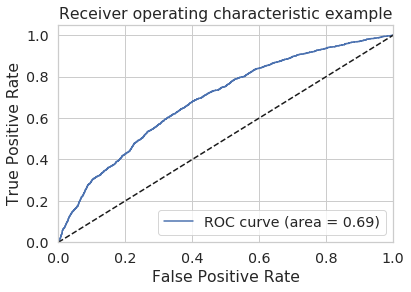

In [212]:
fpr, tpr, thrs = roc_curve(y_test, test_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Salary inequality

In [32]:
df_train['job_name_code'] = df_train['job_name'].astype('category').cat.codes
df_train['gender'] = df_train['gender'].astype('category')
df_train.groupby(['job_name_code', 'gender'])['income'].mean().dropna()

job_name_code  gender
-1             f         64976.946564
               m         64708.863399
 0             f                  NaN
               m         55037.340000
 1             f         24026.350000
                             ...     
 42260         m                  NaN
 42261         f                  NaN
               m         36014.580000
 42262         f                  NaN
               m         33026.120000
Name: income, Length: 84528, dtype: float64

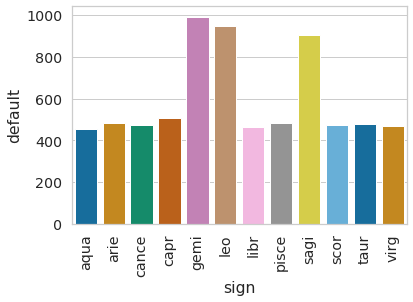

In [24]:
# ax = sns.barplot(x='sign', y='default', data=df_train.groupby('sign').sum()['default'].reset_index(), 
#                  palette='colorblind')
# text = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)